In [1]:
import faceted
import noise_floor
import utils

import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import xarray as xr

import plotting

from constants import CLIMATES
from labels import UNICODE_NAMES, UNITS_UNICODE

In [2]:
REFERENCE = "SHiELD-SOM-C96"
BASELINE = "SHiELD-SOM-C24-tuned-cdmbgwd"
ACE2_SOM = "ACE2-SOM-multi-climate-RS3"
MODELS = [REFERENCE, BASELINE, ACE2_SOM]

regridder = utils.get_regridder()
catalog = utils.open_catalog()
cases = catalog[catalog["model"].isin(MODELS) & catalog["forcing"].isin(CLIMATES)]


In [3]:
ds = utils.load_time_mean_spatial_patterns(
    cases, target_resolution=4, regridder=regridder
)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/home/spencerc/ace2-som-paper/notebooks/utils.py:202: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  result = combined.assign_coords(case=index).unstack("case")


In [4]:
regridded_rmses, regridded_stddevs = noise_floor.compute_regridded_noise_floor(
    regridder, CLIMATES
)

In [5]:
noise_floors = noise_floor.extrapolate(regridded_rmses, 50)
noise_floors = utils.scale_precipitation(noise_floors)

noise_floor_stddevs = noise_floor.extrapolate(regridded_stddevs, 50)
noise_floor_stddevs = utils.scale_precipitation(noise_floor_stddevs)


In [6]:
ensemble_mean = ds.mean("initial_condition")
bias = utils.compute_bias(ensemble_mean, "model", REFERENCE)
rmse = np.sqrt((bias**2).weighted(np.cos(np.deg2rad(bias.lat))).mean(["lon", "lat"]))
rmse = xr.concat([rmse, noise_floors.assign_coords(model="noise-floor")], dim="model")
rmse_no_nans = rmse[[v for v in rmse if rmse[v].notnull().all()]]

In [7]:
percent_improvement = (
    100
    * (rmse_no_nans.sel(model=ACE2_SOM) - rmse_no_nans.sel(model=BASELINE))
    / rmse_no_nans.sel(model=BASELINE)
)


In [8]:
percent_improvement.to_array().min("variable")

<xarray.DataArray (climate: 4)> Size: 32B
array([-94.07102242, -96.68393009, -95.98783088, -96.50631245])
Coordinates:
  * climate  (climate) object 32B '1xCO2' '2xCO2' '3xCO2' '4xCO2'
    param    <U1 4B 'c'
    model    <U28 112B 'SHiELD-SOM-C24-tuned-cdmbgwd'

In [9]:
percent_improvement.to_array().max("variable")

<xarray.DataArray (climate: 4)> Size: 32B
array([-55.72419009, -75.18087506, -53.93295974, -66.7271567 ])
Coordinates:
  * climate  (climate) object 32B '1xCO2' '2xCO2' '3xCO2' '4xCO2'
    param    <U1 4B 'c'
    model    <U28 112B 'SHiELD-SOM-C24-tuned-cdmbgwd'

In [10]:
error_bars = 2 * noise_floor_stddevs  # 95% confidence interval
error_bars = error_bars[list(rmse_no_nans)]
error_bars = error_bars.to_array().sortby("variable").to_dataframe(name="error")

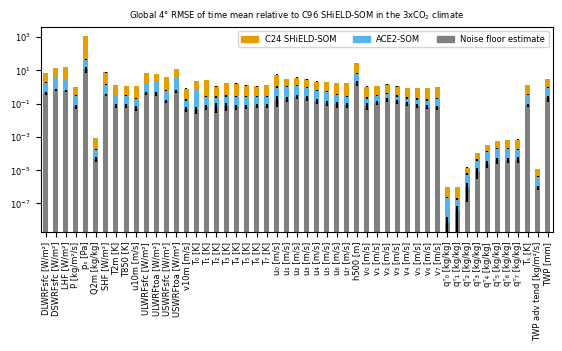

In [11]:
plotting.configure_style(fontsize=6)

fig, (ax,) = faceted.faceted(
    1,
    1,
    width=5.5,
    aspect=0.4,
    left_pad=0.33,
    bottom_pad=1.2,
    top_pad=0.2,
    right_pad=0.05,
)

df = (
    rmse_no_nans.sel(climate="3xCO2", model=BASELINE)
    .to_array()
    .sortby("variable")
    .to_dataframe(name="RMSE")
)
index = pd.Index(
    [f"{UNICODE_NAMES[name]} [{UNITS_UNICODE[name]}]" for name in df.index]
)
df = df.set_index(index)
df.plot.bar(
    ax=ax,
    logy=True,
    legend=False,
    color="C1",
    yerr=error_bars["error"].values,
    capsize=0,
)

df = (
    rmse_no_nans.sel(climate="3xCO2", model=ACE2_SOM)
    .to_array()
    .sortby("variable")
    .to_dataframe(name="RMSE")
)
index = pd.Index(
    [f"{UNICODE_NAMES[name]} [{UNITS_UNICODE[name]}]" for name in df.index]
)
df = df.set_index(index)
df.plot.bar(
    ax=ax,
    logy=True,
    legend=False,
    color="C0",
    yerr=error_bars["error"].values,
    capsize=0,
)

df = (
    rmse_no_nans.sel(climate="3xCO2", model="noise-floor")
    .to_array()
    .sortby("variable")
    .to_dataframe(name="RMSE")
)
index = pd.Index(
    [f"{UNICODE_NAMES[name]} [{UNITS_UNICODE[name]}]" for name in df.index]
)
df = df.set_index(index)
df.plot.bar(
    ax=ax,
    logy=True,
    legend=False,
    color="gray",
    yerr=error_bars["error"].values,
    capsize=0,
)

ax.set_title(
    "Global 4° RMSE of time mean relative to C96 SHiELD-SOM in the 3xCO$_2$ climate"
)

baseline_patch = mpatches.Patch(color="C1", label="C24 SHiELD-SOM")
ace_patch = mpatches.Patch(color="C0", label="ACE2-SOM")
noise_floor_patch = mpatches.Patch(color="gray", label="Noise floor estimate")

ax.legend(handles=[baseline_patch, ace_patch, noise_floor_patch], ncol=3, fontsize=6)
fig.savefig("figures/figure-02.pdf")
fig.savefig("figures/figure-02.png", dpi=200)

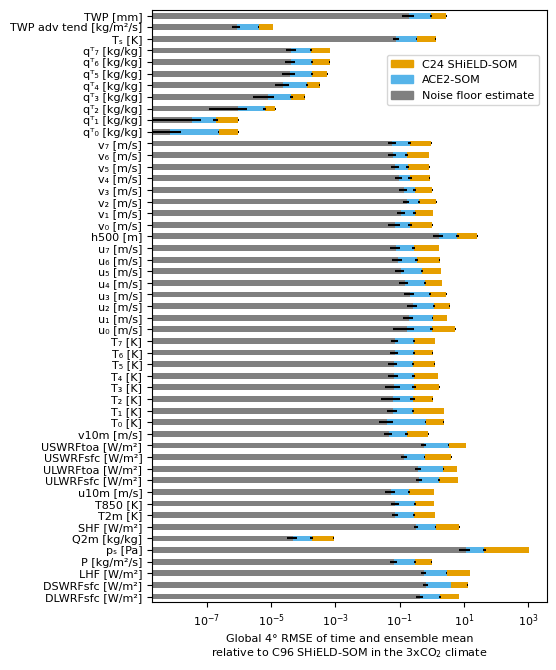

In [12]:
plotting.configure_style()

fig, (ax,) = faceted.faceted(
    1,
    1,
    width=5.5,
    aspect=1.5,
    left_pad=1.5,
    bottom_pad=0.55,
    top_pad=0.05,
    right_pad=0.05,
)

df = (
    rmse_no_nans.sel(climate="3xCO2", model=BASELINE)
    .to_array()
    .sortby("variable")
    .to_dataframe(name="RMSE")
)
index = pd.Index(
    [f"{UNICODE_NAMES[name]} [{UNITS_UNICODE[name]}]" for name in df.index]
)
df = df.set_index(index)
df.plot.barh(
    ax=ax,
    logx=True,
    legend=False,
    color="C1",
    xerr=error_bars["error"].values,
    capsize=0,
)

df = (
    rmse_no_nans.sel(climate="3xCO2", model=ACE2_SOM)
    .to_array()
    .sortby("variable")
    .to_dataframe(name="RMSE")
)
index = pd.Index(
    [f"{UNICODE_NAMES[name]} [{UNITS_UNICODE[name]}]" for name in df.index]
)
df = df.set_index(index)
df.plot.barh(
    ax=ax,
    logx=True,
    legend=False,
    color="C0",
    xerr=error_bars["error"].values,
    capsize=0,
)

df = (
    rmse_no_nans.sel(climate="3xCO2", model="noise-floor")
    .to_array()
    .sortby("variable")
    .to_dataframe(name="RMSE")
)
index = pd.Index(
    [f"{UNICODE_NAMES[name]} [{UNITS_UNICODE[name]}]" for name in df.index]
)
df = df.set_index(index)
df.plot.barh(
    ax=ax,
    logx=True,
    legend=False,
    color="gray",
    xerr=error_bars["error"].values,
    capsize=0,
)

ax.set_title("")
ax.set_xlabel(
    "Global 4° RMSE of time and ensemble mean\nrelative to C96 SHiELD-SOM in the 3xCO$_2$ climate"
)

baseline_patch = mpatches.Patch(color="C1", label="C24 SHiELD-SOM")
ace_patch = mpatches.Patch(color="C0", label="ACE2-SOM")
noise_floor_patch = mpatches.Patch(color="gray", label="Noise floor estimate")

ax.legend(
    handles=[baseline_patch, ace_patch, noise_floor_patch],
    fontsize=8,
    bbox_to_anchor=(0.58, 0.83),
    bbox_transform=ax.transAxes,
)
fig.savefig("figures/figure-02-barh.pdf")
fig.savefig("figures/figure-02-barh.png", dpi=200)